# Magnificacion de Movimiento con y sin Bounding Box

### Acontinuacion ponga la ruta en la se encuentra este notebook y el nombre del video que dese procesar

In [36]:
path = '/home/brayan/Documentos/Stsiva_code/'
video = 'pk1.mp4/'

In [37]:
import subprocess

In [38]:
subprocess.call(['bash', 'Recortar_Video.sh', 'DSC_0017.MOV', '00:00:00', '00:00:07', 'std_7.mp4'])

1

In [39]:
subprocess.call(['bash', 'sacar_fotogramas.sh', path, video[:-1], video[:-1]])

0

# Funciones 

In [40]:
def sort_dir(path):
    import os
    frames = os.listdir(path)

    indices=[]

    for i in frames:
        indices.append(int(i[10:13]))


    sort_indices = np.sort(indices)
    sort_frames = []       
    for i in sort_indices:
            if i<10:
                sort_frames.append("fotograma-00"+str(i)+".png") 
            elif i<100:  
                 sort_frames.append("fotograma-0"+str(i)+".png")
            else:
                 sort_frames.append("fotograma-"+str(i)+".png")
    return sort_frames

def centro_demasa(img):
    
    from scipy import ndimage
    mass_center_tuple = ndimage.measurements.center_of_mass(img)
    if np.isnan(mass_center_tuple[0]) and np.isnan(mass_center_tuple[1]):
        
        mass_center = [0,0]
        return mass_center
    
    else:
        
        mass_center=[int(mass_center_tuple[0]),int(mass_center_tuple[1])]
        return mass_center
    
def aumentar_vector(b, a, alfa):
    if b == 0:
        return b, int(a*alfa)
    elif a == 0:
        return int(b*alfa), a
    else:
        c = alfa*a
        d = b*c/a
        return int(d), int(c)
    
def bg_sustraction(path, frames):
    
    h,w = cv2.imread(path + frames[0],1).shape[:2]
    suma_frames = np.zeros(shape=(int(h),int(w),3))
    cantidad_de_frames = 0
    for frame in frames:
        suma_frames = suma_frames + cv2.imread(path + frame, 1)
        cantidad_de_frames = cantidad_de_frames + 1
    
    bg = suma_frames/cantidad_de_frames
    return bg

def norm_y(array):
    from sklearn.preprocessing import normalize
    array_copiax = array[:,1]
    array = normalize(array, axis=0, norm='max')
    array[:,1] = array_copiax
    return array

def norma_media(array):
    media = np.mean(array[:,0])
    array[:,0] = array[:,0] - media
    return array

def Dibujar(puntos_1,puntos_2,etiqueta):
    import matplotlib.pyplot as plt
    plt.plot(puntos_1[:,1],puntos_1[:,0], '-r')
    plt.plot(puntos_2[:,1],puntos_2[:,0], '-b') 
    plt.legend( ('Magnified', 'Standard',), loc = 'upper right') 
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig(etiqueta + '.jpg', bbox_inches='tight')
    plt.show()

def recortar_array(a,b,array):
    
    array =array[array[:,1]>a]
    array =array[array[:,1]<b]
    return array

def cross_corelation(centro_1, centro_2, Etiqueta, mode):
    from scipy import signal
    import matplotlib.pyplot as plt
    if mode == 0:

        corr = signal.correlate(centro_1[:,0], centro_2[:,0], mode = 'valid')
        br_n =np.max(corr)
        plt.plot(corr)
        plt.xlabel('x')
        plt.ylabel('y')
        #plt.title(Etiqueta)
        plt.savefig(Etiqueta +'.jpg', bbox_inches='tight')
        plt.show()
        return corr
    
        
def Pintar(puntos, etiqueta):
    import matplotlib.pyplot as plt
    plt.plot(puntos[:,1],puntos[:,0], '-r')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(etiqueta)
    plt.savefig(etiqueta + '.jpg', bbox_inches='tight')
    plt.show()
    
def norma_media_x(array):
    media = np.mean(array)
    array = array - media
    return array

# Magnificacion Paso a Paso

In [41]:
import numpy as np
import cv2

In [42]:
Frames_Originales = sort_dir(path + video)

In [43]:
carpeta_de_region = 'region'
carpeta_de_region_color = 'region_color'
subprocess.call(['mkdir', carpeta_de_region])
subprocess.call(['mkdir', 'Segmentacion'])
subprocess.call(['mkdir', carpeta_de_region_color])
fgbg = cv2.bgsegm.createBackgroundSubtractorMOG()


for frame in Frames_Originales:
    
    img = cv2.imread(path + video + frame)
    Segmentacion = fgbg.apply(img)
    cv2.imwrite(path + 'Segmentacion/' + frame , Segmentacion)
    y, x = img.shape[:2]
    copia_1 = np.zeros((y,x,3))
    copia_2 = np.zeros((y,x,3))
    cm = centro_demasa(Segmentacion)
    copia_1[cm[0]-100:cm[0]+101,cm[1]-100:cm[1]+101] = img[cm[0]-100:cm[0]+101,cm[1]-100:cm[1]+101]
    copia_2[cm[0]-100:cm[0]+101,cm[1]-100:cm[1]+101] = 255
    cv2.imwrite(path + carpeta_de_region + '/' + frame, copia_2)
    cv2.imwrite(path + carpeta_de_region_color + '/' + frame, copia_1)

In [44]:
Frames_Region = sort_dir(path + carpeta_de_region)
total_de_frames = len(Frames_Region)
print total_de_frames

228


In [45]:
carpeta_de_aumento = 'Aumento'
alfa = 6
subprocess.call(['mkdir', carpeta_de_aumento])
for i,frame in enumerate(Frames_Region):
    if i != total_de_frames-1:
        img_1 = cv2.imread(path + carpeta_de_region + '/' + Frames_Region[i], 0)
        img_1_color = cv2.imread(path + carpeta_de_region_color + '/' + Frames_Region[i])
        img_2 = cv2.imread(path + carpeta_de_region + '/' + Frames_Region[i+1], 0)
        y, x = img_1.shape[:2]
        img_1_aumentada = np.zeros((y,x,3))
        cm_1 = np.array(centro_demasa(img_1))
        cm_2 = np.array(centro_demasa(img_2))
        if np.average(cm_1) != 0 and np.average(cm_2) != 0:
            cm  = cm_2 - cm_1
            y_cm, x_cm = aumentar_vector(cm[0], cm[1], alfa)
            y_cm = y_cm + cm_1[0]
            x_cm = x_cm + cm_1[1]
            try:
                img_1_aumentada[y_cm - 100:y_cm + 101, x_cm - 100:x_cm + 101] = img_1_color[cm_1[0] - 100:cm_1[0] + 101,cm_1[1] - 100:cm_1[1] + 101]
                cv2.imwrite(path + carpeta_de_aumento + '/' + frame, img_1_aumentada)
            except ValueError:
                cv2.imwrite(path + carpeta_de_aumento + '/' + frame, img_1_color)
        else:
            cv2.imwrite(path + carpeta_de_aumento + '/' + frame, img_1_color)

In [46]:
Frames_Aumentados = sort_dir(path + carpeta_de_aumento)
total_de_frames = len(Frames_Region)
print total_de_frames
bg = bg_sustraction(path + video + '/', Frames_Originales)

228


In [47]:
for frame in Frames_Aumentados:
    img = cv2.imread(path + carpeta_de_aumento + '/' + frame)
    img_grises = cv2.imread(path + carpeta_de_aumento + '/' + frame, 0)
    mascara = img_grises == 0
    img[mascara] = bg[mascara]
    cv2.imwrite(path + carpeta_de_aumento + '/' + frame, img)

In [48]:
subprocess.call(['bash', 'armar_video.sh', video[:-1] + '_Aumentado' + str(alfa) +'.mp4',carpeta_de_aumento, '25'])

0

# Funcion para Magnificar 

In [10]:
def Aumento(alfa, video):
    import numpy as np
    import cv2
    
    cm_normal = []
    cm_aumentado = []
    
    subprocess.call(['bash', 'sacar_fotogramas.sh', path, video[:-1], video[:-1]])
    
    Frames_Originales = sort_dir(path + video)
    carpeta_de_region = 'region'
    carpeta_de_region_color = 'region_color'
    subprocess.call(['mkdir', carpeta_de_region])
    subprocess.call(['mkdir', 'Segmentacion'])
    subprocess.call(['mkdir', carpeta_de_region_color])
    fgbg = cv2.bgsegm.createBackgroundSubtractorMOG()

    for frame in Frames_Originales:
    
        img = cv2.imread(path + video + frame)
        Segmentacion = fgbg.apply(img)
        cv2.imwrite(path + 'Segmentacion/' + frame , Segmentacion)
        y, x = img.shape[:2]
        copia_1 = np.zeros((y,x,3))
        copia_2 = np.zeros((y,x,3))
        cm = centro_demasa(Segmentacion)
        copia_1[cm[0]-100:cm[0]+101,cm[1]-100:cm[1]+101] = img[cm[0]-100:cm[0]+101,cm[1]-100:cm[1]+101]
        copia_2[cm[0]-100:cm[0]+101,cm[1]-100:cm[1]+101] = 255
        cv2.imwrite(path + carpeta_de_region + '/' + frame, copia_2)
        cv2.imwrite(path + carpeta_de_region_color + '/' + frame, copia_1)
    
    Frames_Region = sort_dir(path + carpeta_de_region)
    total_de_frames = len(Frames_Region)
    print total_de_frames
    
    carpeta_de_aumento = 'Aumento'
    subprocess.call(['mkdir', carpeta_de_aumento])
    for i,frame in enumerate(Frames_Region):
        if i != total_de_frames-1:
            img_1 = cv2.imread(path + carpeta_de_region + '/' + Frames_Region[i], 0)
            img_1_color = cv2.imread(path + carpeta_de_region_color + '/' + Frames_Region[i])
            img_2 = cv2.imread(path + carpeta_de_region + '/' + Frames_Region[i+1], 0)
            y, x = img_1.shape[:2]
            img_1_aumentada = np.zeros((y,x,3))
            cm_1 = np.array(centro_demasa(img_1))
            cm_2 = np.array(centro_demasa(img_2))
            if np.average(cm_1) != 0 and np.average(cm_2) != 0:
                cm  = cm_2 - cm_1
                y_cm, x_cm = aumentar_vector(cm[0], cm[1], alfa)
                y_cm = y_cm + cm_1[0]
                x_cm = x_cm + cm_1[1]
                try:
                    cm_normal.append(cm_1)
                    cm_aumentado.append([y_cm, x_cm])
                    img_1_aumentada[y_cm - 100:y_cm + 101, x_cm - 100:x_cm + 101] = img_1_color[cm_1[0] - 100:cm_1[0] + 101,cm_1[1] - 100:cm_1[1] + 101]
                    cv2.imwrite(path + carpeta_de_aumento + '/' + frame, img_1_aumentada)
                except ValueError:
                    cv2.imwrite(path + carpeta_de_aumento + '/' + frame, img_1_color)
            else:
                cv2.imwrite(path + carpeta_de_aumento + '/' + frame, img_1_color)
    
    Frames_Aumentados = sort_dir(path + carpeta_de_aumento)
    total_de_frames = len(Frames_Region)
    print total_de_frames
    bg = bg_sustraction(path + video + '/', Frames_Originales)
    
    for frame in Frames_Aumentados:
        img = cv2.imread(path + carpeta_de_aumento + '/' + frame)
        img_grises = cv2.imread(path + carpeta_de_aumento + '/' + frame, 0)
        mascara = img_grises == 0
        img[mascara] = bg[mascara]
        cv2.imwrite(path + carpeta_de_aumento + '/' + frame, img)
        
    subprocess.call(['bash', 'armar_video.sh', video[:-1] + '_Aumentado' + str(alfa) +'.mp4',carpeta_de_aumento, '25'])
    subprocess.call(['rm','-r', video])
    !rm -r Aumento
    !rm -r region
    !rm -r region_color
    !rm -r Segmentacion
    return np.array(cm_normal), np.array(cm_aumentado)

In [67]:
pk1 = 'Pk_1.mp4/'
pk2 = 'Pk_2.mp4/'
std1 = 'std_1.mp4/'
std2 = 'std_2.mp4/'

In [237]:
alfa = 8
cm_normal_pk_1, cm_aumentado_pk_1 = Aumento(alfa, pk1)
cm_normal_pk_2, cm_aumentado_pk_2 = Aumento(alfa, pk2)
cm_normal_std_1, cm_aumentado_std_1 = Aumento(alfa, std1)
cm_normal_std_2, cm_aumentado_std_2 = Aumento(alfa, std2)

201
201
202
202
151
151
127
127


In [238]:
cm_normal_pk_1 = recortar_array(250, 1750, cm_normal_pk_1)
cm_aumentado_pk_1 = recortar_array(400, 1750, cm_aumentado_pk_1)
cm_normal_pk_2 = recortar_array(250, 1750, cm_normal_pk_2)
cm_aumentado_pk_2 = recortar_array(400, 1750, cm_aumentado_pk_2)
cm_normal_std_1 = recortar_array(250, 1750, cm_normal_std_1)
cm_aumentado_std_1 = recortar_array(400, 1750, cm_aumentado_std_1)
cm_normal_std_2 = recortar_array(250, 1750, cm_normal_std_2)
cm_aumentado_std_2 = recortar_array(400, 1750, cm_aumentado_std_2)

subprocess.call(['mkdir', 'tool'])
Frames_Originales = sort_dir(path + video)
bg = bg_sustraction(path + video, Frames_Originales)
y, x = cm_aumentado.shape 
altura_prom = int(np.average(cm_normal[:,0]))
for frame in Frames_Originales:
    cv2.imwrite(path + 'tool/' +frame,bg)

Frames_back = sort_dir(path + 'tool/')
#print(Frames_back)

for i in range(y):
    img = cv2.imread(path + 'tool/' + Frames_back[i])
    cv2.circle(img,(cm_normal[i,1],cm_normal[i,0]), 20, (255,0,0), -1)
    cv2.circle(img,(cm_aumentado[i,1],cm_aumentado[i,0]), 20, (0,255,0), -1)
    cv2.line(img,(0,altura_prom),(1919,altura_prom),(255,255,255),5)
    j = i
    while j >= 1:
    
        img = cv2.line(img,(cm_normal[j,1],cm_normal[j,0]),(cm_normal[j - 1,1],cm_normal[j - 1,0]),(255,0,0),5)
        img = cv2.line(img,(cm_aumentado[j,1],cm_aumentado[j,0]),(cm_aumentado[j - 1,1],cm_aumentado[j - 1,0]),(0,255,0),5)

        j = j-1
    cv2.imwrite(path + 'tool/' + Frames_back[i],img)

In [239]:
cm_normal_pk_1 = norm_y(cm_normal_pk_1)
cm_aumentado_pk_1 = norm_y(cm_aumentado_pk_1)
cm_normal_pk_1 = norma_media(cm_normal_pk_1)
cm_aumentado_pk_1 = norma_media(cm_aumentado_pk_1)
cm_normal_pk_2 = norm_y(cm_normal_pk_2)
cm_aumentado_pk_2 = norm_y(cm_aumentado_pk_2)
cm_normal_pk_2 = norma_media(cm_normal_pk_2)
cm_aumentado_pk_2 = norma_media(cm_aumentado_pk_2)
cm_normal_std_1 = norm_y(cm_normal_std_1)
cm_aumentado_std_1 = norm_y(cm_aumentado_std_1)
cm_normal_std_1 = norma_media(cm_normal_std_1)
cm_aumentado_std_1 = norma_media(cm_aumentado_std_1)
cm_normal_std_2 = norm_y(cm_normal_std_2)
cm_aumentado_std_2 = norm_y(cm_aumentado_std_2)
cm_normal_std_2 = norma_media(cm_normal_std_2)
cm_aumentado_std_2 = norma_media(cm_aumentado_std_2)

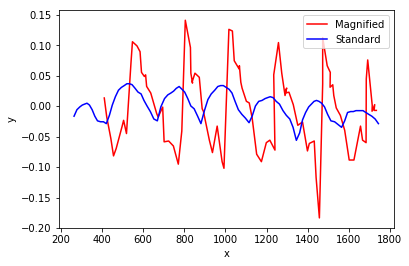

In [240]:
Dibujar(cm_aumentado_pk_1, cm_normal_pk_1, 'Standard_pk1 vs Magnified_pk1 '+ 'alfa = ' + str(alfa))

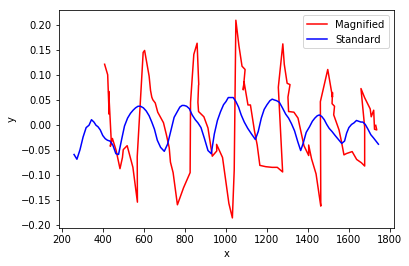

In [241]:
Dibujar(cm_aumentado_pk_2, cm_normal_pk_2, 'Standard_pk2 vs Magnified_pk2 '+ 'alfa = ' + str(alfa))

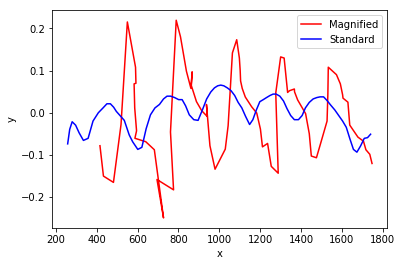

In [242]:
Dibujar(cm_aumentado_std_1, cm_normal_std_1, 'Standard_std1 vs Magnified_std1 '+ 'alfa = ' + str(alfa))

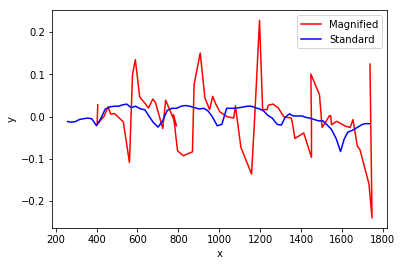

In [243]:
Dibujar(cm_aumentado_std_2, cm_normal_std_2, 'Standard_std2 vs Magnified_std2 '+ 'alfa = ' + str(alfa))

# Segmentos Representativos

In [244]:
cm_normal_pk_1 = recortar_array(660, 890, cm_normal_pk_1)
cm_aumentado_pk_1 = recortar_array(750, 910, cm_aumentado_pk_1)
cm_normal_std_1 = recortar_array(890, 1150, cm_normal_std_1)
cm_aumentado_std_1 = recortar_array(1000, 1200, cm_aumentado_std_1)

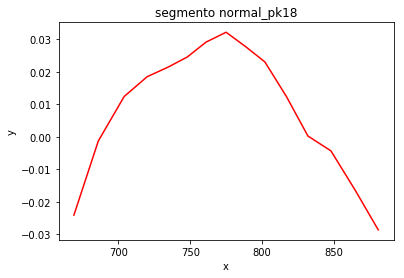

In [245]:
Pintar(cm_normal_pk_1,'segmento normal_pk1' + str(alfa))

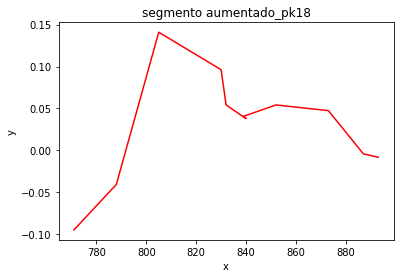

In [246]:
Pintar(cm_aumentado_pk_1,'segmento aumentado_pk1'+ str(alfa))

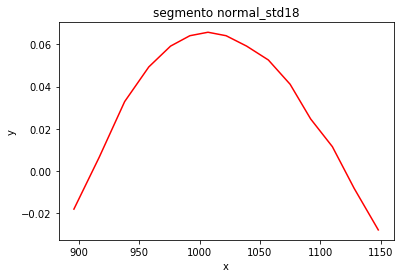

In [247]:
Pintar(cm_normal_std_1,'segmento normal_std1'+ str(alfa))

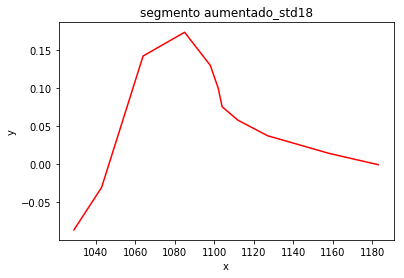

In [248]:
Pintar(cm_aumentado_std_1,'segmento aumentado_std1'+ str(alfa))

# correlacion entre centros con parkinson y centros estandar

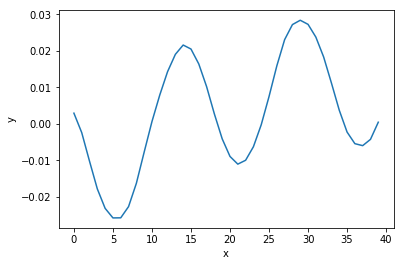

array([ 0.0029028 , -0.00243108, -0.01029025, -0.01788886, -0.02322633,
       -0.0258491 , -0.02582321, -0.02274852, -0.01636446, -0.00779683,
        0.00059988,  0.00788757,  0.01429643,  0.01905392,  0.02160968,
        0.02050957,  0.01641396,  0.01020245,  0.00267532, -0.00414151,
       -0.0089768 , -0.01108465, -0.01002414, -0.00630725, -0.00028134,
        0.00746251,  0.01589198,  0.02308806,  0.02722315,  0.02841476,
        0.02728658,  0.02379195,  0.01832458,  0.01115907,  0.00371657,
       -0.00227518, -0.0054653 , -0.00601079, -0.0042861 ,  0.00042146])

In [249]:
cross_corelation(cm_normal_pk_2,cm_normal_std_2,'correlacion entre normal_pk2 y normal_std2 ' ,0)

# correlacion entre segmentos representativo y marchas

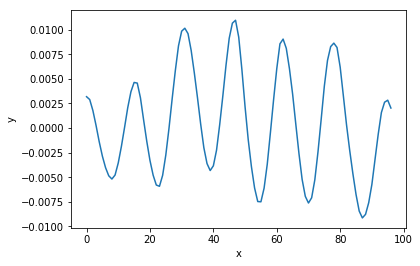

In [250]:
cross1 = cross_corelation(cm_normal_pk_1,cm_normal_pk_2,'correlacion entre segmento normal_pk1 y normal_pk2 ',0)

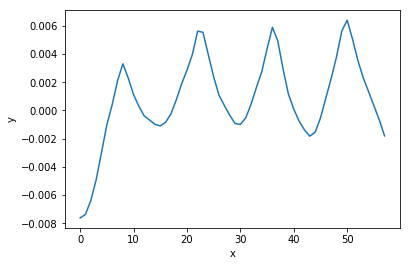

In [251]:
cross2 = cross_corelation(cm_normal_pk_1,cm_normal_std_2,'correlacion entre segmento normal_pk1 y normal_std2 ',0)

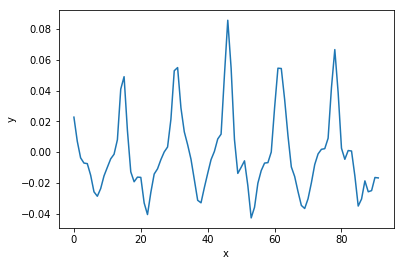

In [252]:
cross3 = cross_corelation(cm_aumentado_pk_1,cm_aumentado_pk_2,'correlacion entre segmento aumentado_pk1 y aumentado_pk2 ',0)

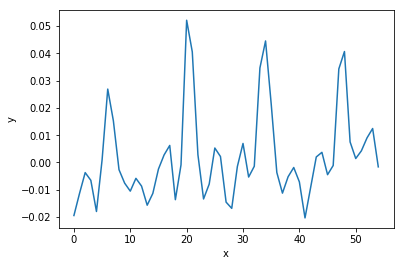

In [253]:
cross4 = cross_corelation(cm_aumentado_pk_1,cm_aumentado_std_2,'correlacion entre segmento aumentado_pk1 y aumentado_std2 ',0)

In [254]:
cross1.shape

(97,)

In [255]:
corss1 = norma_media_x(cross1)
corss2 = norma_media_x(cross2)
corss3 = norma_media_x(cross3)
corss4 = norma_media_x(cross4)

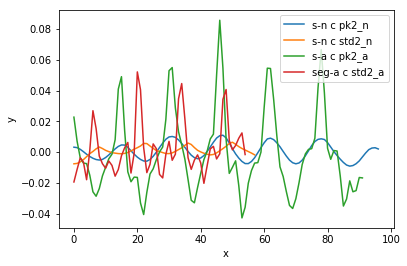

In [256]:
import matplotlib.pyplot as plt
plt.plot(cross1)
plt.plot(cross2)
plt.plot(cross3)
plt.plot(cross4)
plt.legend( ('s-n c pk2_n','s-n c std2_n','s-a c pk2_a','seg-a c std2_a'), loc = 'upper right')
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('correlaciones-pk' + str(alfa) + '.jpg', bbox_inches='tight')
plt.show()

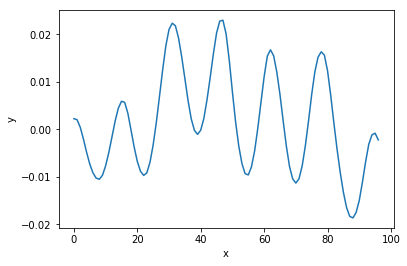

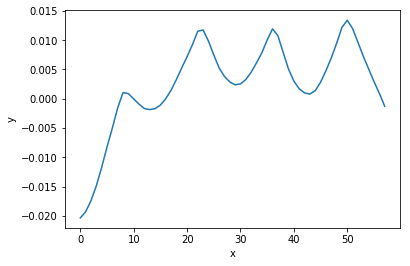

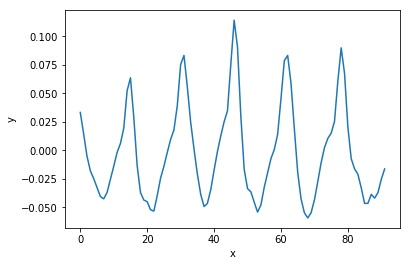

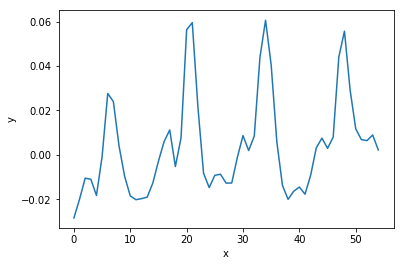

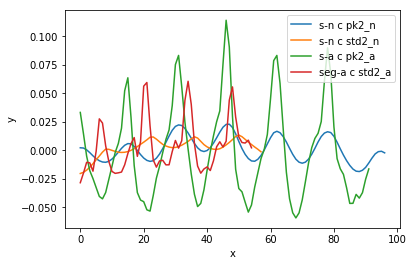

In [257]:
cross1 = cross_corelation(cm_normal_std_1,cm_normal_pk_2,'correlacion entre segmento normal_pk1 y normal_pk2',0)
cross2 = cross_corelation(cm_normal_std_1,cm_normal_std_2,'correlacion entre segmento normal_pk1 y normal_std2',0)
cross3 = cross_corelation(cm_aumentado_std_1,cm_aumentado_pk_2,'correlacion entre segmento aumentado_pk1 y aumentado_pk2',0)
cross4 = cross_corelation(cm_aumentado_std_1,cm_aumentado_std_2,'correlacion entre segmento aumentado_pk1 y aumentado_std2',0)

corss1 = norma_media_x(cross1)
corss2 = norma_media_x(cross2)
corss3 = norma_media_x(cross3)
corss4 = norma_media_x(cross4)

import matplotlib.pyplot as plt
plt.plot(cross1)
plt.plot(cross2)
plt.plot(cross3)
plt.plot(cross4)
plt.legend( ('s-n c pk2_n','s-n c std2_n','s-a c pk2_a','seg-a c std2_a'), loc = 'upper right')
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('correlaciones-std' + str(alfa) + '.jpg', bbox_inches='tight')
plt.show()